In [1]:
import pandas as pd
import re
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pycountry
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
df_2002 = pd.read_csv("./final_csv/2002.csv")
df_2012 = pd.read_csv("./final_csv/2012.csv")
df_2022 = pd.read_csv("./final_csv/2022.csv")

In [3]:
df_2002 = df_2002[(df_2002["marital"] == "Married") & (df_2002["age"] >= 18)]
df_2012 = df_2012[(df_2012["marital"] == "Married") & (df_2012["age"] >= 18)]
df_2022 = df_2022[(df_2022["marital"] == "Married") & (df_2022["age"] >= 18)]

In [4]:
def normalize_column(series):
    """
    Normalize a numeric series to 0-1 range using min-max scaling.
    """
    return (series - series.min()) / (series.max() - series.min())

# Apply to eg_score columns
df_2002['eg_score_norm'] = normalize_column(df_2002['eg_score'])
df_2012['eg_score_norm'] = normalize_column(df_2012['eg_score'])
df_2022['eg_score_norm'] = normalize_column(df_2022['eg_score'])

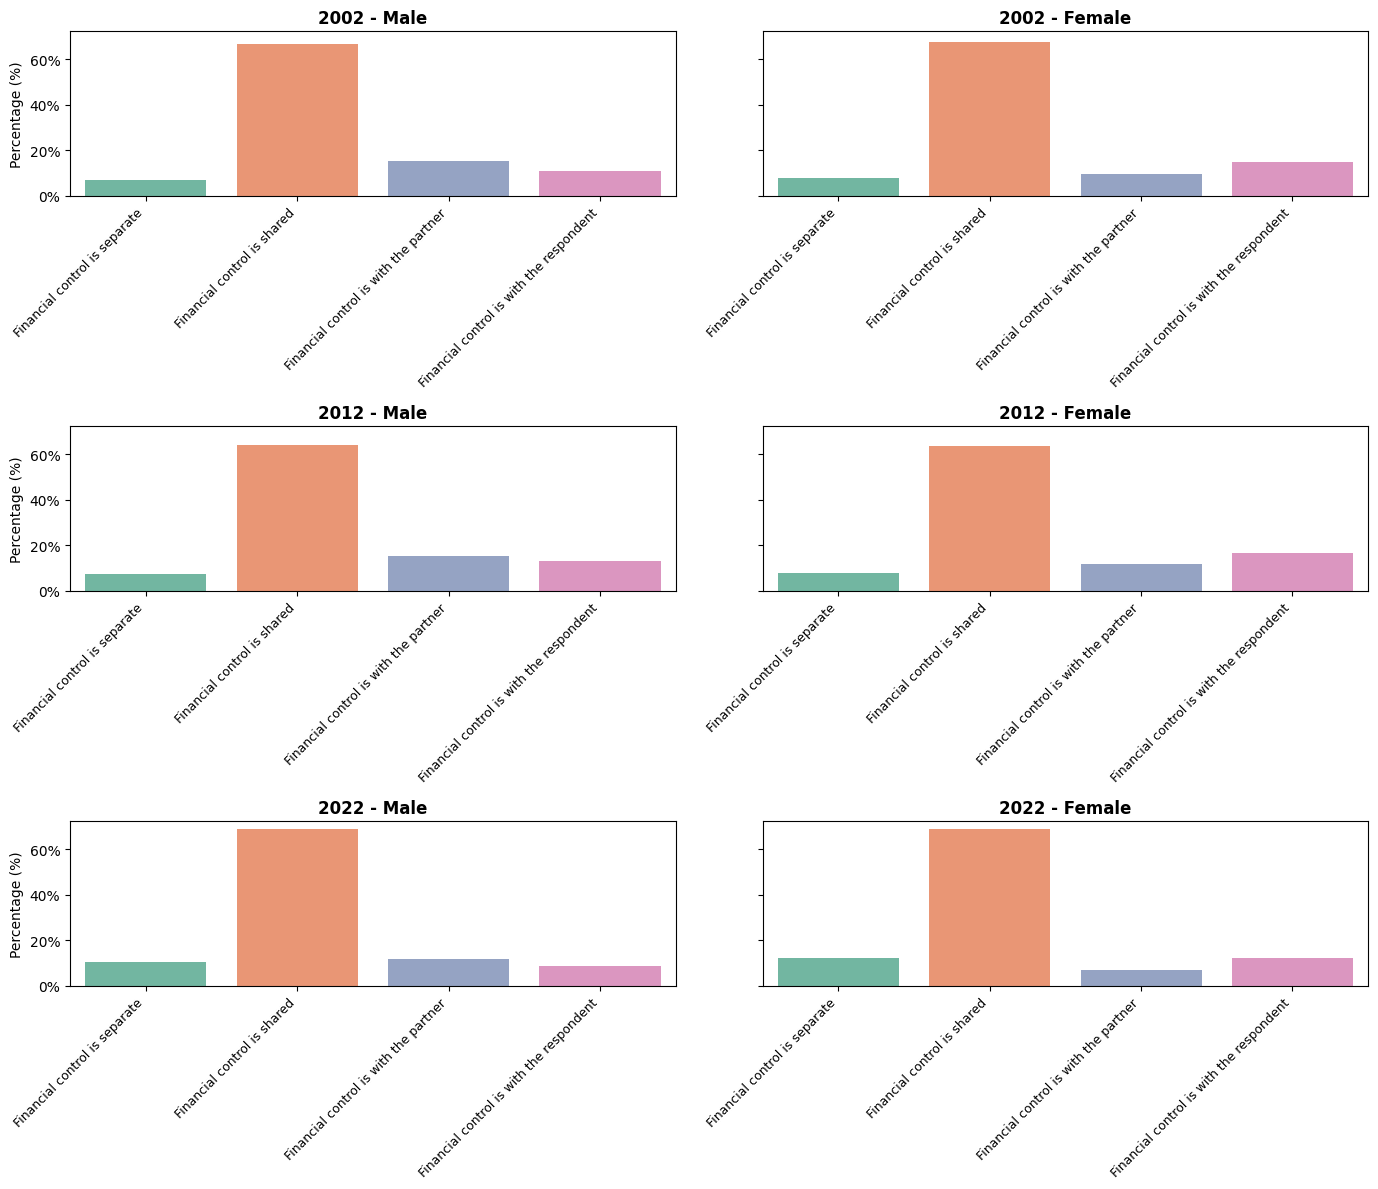

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sex_labels = ["Male", "Female"]

for row, (year, df) in enumerate(zip(years, dfs)):
    for col, sex in enumerate(sex_labels):
        ax = axes[row, col]
        
        if year == 2002:
            sub = df[(df["sex"] == sex) & (df["marital"] == "Married")]
        elif year == 2012:
            sub = df[(df["sex"] == sex) & (df["marital"] == "Married")]
        else:  # 2022
            sub = df[(df["sex"] == sex) & (df["marital"] == 'Married')]
        
        vc = sub["code_income_control"].value_counts(normalize=True) * 100
        vc = vc.sort_index()
        
        sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="Set2")
        ax.set_title(f"{year} - {sex}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Percentage (%)" if col == 0 else "")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
df_2002.name = "df_2002"
df_2012.name = "df_2012"
df_2022.name = "df_2022"

In [7]:
years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

results = []

for year, df in zip(years, dfs):
    if year == 2002:
        male = df[(df["sex"] == "Male") & (df["marital"] == "Married")]
        female = df[(df["sex"] == "Female") & (df["marital"] == "Married")]
    elif year == 2012:
        male = df[(df["sex"] == "Male") & (df["marital"] == "Married")]
        female = df[(df["sex"] == "Female") & (df["marital"] == "Married")]
    else:  # 2022
        male = df[(df["sex"] == "Male") & (df["marital"] == "Married")]
        female = df[(df["sex"] == "Female") & (df["marital"] == "Married")]
    

    # keep only single-person control
    male_single = male[male["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]
    # print(len(male_single))
    female_single = female[female["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]

    results.append({
        "Year": year,
        "Male share": len(male_single) / (len(male_single) + len(female_single)) * 100,
        "Female share": len(female_single) / (len(male_single) + len(female_single)) * 100
    })

res_df = pd.DataFrame(results)
res_df

,Year,Male share,Female share
0,2002,48.363746,51.636254
1,2012,49.474596,50.525404
2,2022,50.727017,49.272983


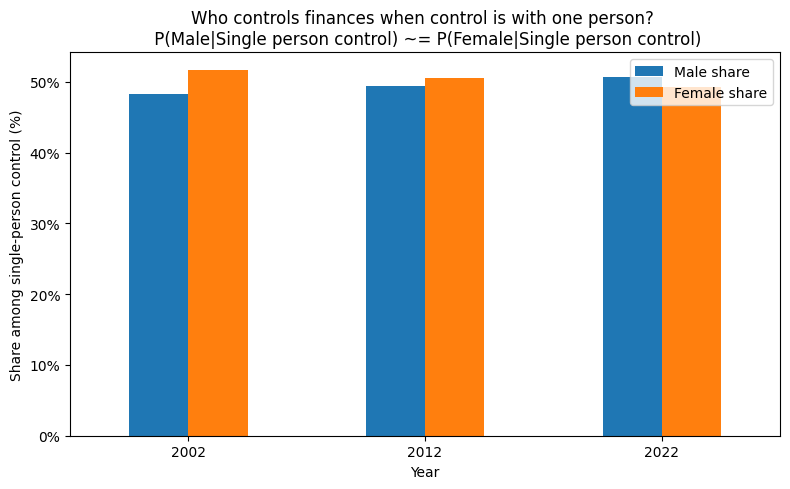

In [8]:
res_df.set_index("Year")[["Male share", "Female share"]].plot(
    kind="bar",
    figsize=(8, 5)
)

plt.ylabel("Share among single-person control (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Who controls finances when control is with one person? \n P(Male|Single person control) ~= P(Female|Single person control)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [9]:
# No co-relation between education and financial control
print(df_2012[df_2012["code_income_control"].isin(["Financial control is with the partner"])][["educ_4_label"]].value_counts())
print(df_2012[df_2012["code_income_control"].isin(["Financial control is with the respondent"])][["educ_4_label"]].value_counts())

educ_4_label             
Secondary                    2599
No/Primary                   1121
Post-sec / Short tertiary     543
University+                   140
Name: count, dtype: int64
educ_4_label             
Secondary                    2846
No/Primary                   1118
Post-sec / Short tertiary     592
University+                   206
Name: count, dtype: int64


In [10]:
df_2012[df_2012["code_income_control"].isin(["Financial control is with the partner"])][["work_status"]].value_counts() #MAINSTAT
# df_2012[df_2012["code_income_control"].isin(["Financial control is with the respondent"])][["MAINSTAT"]].value_counts() #SPMAINST

work_status       
Paid work             2157
Domestic work          904
Retired                712
Unemployed             286
Other                  179
Sick/Disabled          102
Education               47
DK/No answer            42
Apprentice/Trainee       8
Name: count, dtype: int64

In [11]:
df_2012[(df_2012["work_status"] == "Unemployed") & (df_2012["sex"] == "Male")]["code_income_control"].value_counts()

code_income_control
Financial control is shared                 404
Financial control is with the partner       135
Financial control is with the respondent    123
Financial control is separate                41
Name: count, dtype: int64

The below cell tries to identify if there is a relation between higher income and financial control. 
We saw that the financial control is shared in most of the cases, so the hypothesis is that men believe in equality and share financial control. 
We also want to check if income has any effect on financial control. Men are generally paid higher, so what if in cases where the financial control is not shared, it is because of higher income. 
If that is also not true, i.e. having high income does not have an effect on financial control, then men believe in equality in financial control. 

In [12]:
base = df_2012[
    (df_2012["marital"] == "Married")
    & (df_2012["sex"] == "Male")
].copy()

tab = (
    base.groupby("code_higher_income")["code_income_control"]
        .value_counts()
        .unstack(fill_value=0)
)
tab

code_income_control,Financial control is separate,Financial control is shared,Financial control is with the partner,Financial control is with the respondent
code_higher_income,,,,
Partner has higher income,164,1110,284,106
Partner has no income,66,1001,483,690
Respondent has higher income,312,2485,606,592
Respondent has no income,12,162,96,48


In [13]:
chi2, p, dof, expected = chi2_contingency(tab)

print(f"Chi-square: {chi2:.2f}")
print(f"p-value: {p:.4f}")


Chi-square: 611.22
p-value: 0.0000


In [14]:
tab_pct = tab.div(tab.sum(axis=1), axis=0) * 100
tab_pct.round(1)

code_income_control,Financial control is separate,Financial control is shared,Financial control is with the partner,Financial control is with the respondent
code_higher_income,,,,
Partner has higher income,9.9,66.7,17.1,6.4
Partner has no income,2.9,44.7,21.6,30.8
Respondent has higher income,7.8,62.2,15.2,14.8
Respondent has no income,3.8,50.9,30.2,15.1


In [15]:
base = df_2002[
    (df_2002["marital"] == "Married")
    & (df_2002["sex"] == "Male")
].copy()

tab = (
    base.groupby("code_higher_income")["code_income_control"]
        .value_counts()
        .unstack(fill_value=0)
)
tab

chi2, p, dof, expected = chi2_contingency(tab)

print(f"Chi-square: {chi2:.2f}")
print(f"p-value: {p:.4f}")


Chi-square: 1266.45
p-value: 0.0000


The above hypothesis is not possible for the year 2022 as the `code_higher_income` variable is not available

In [16]:
df_2002[df_2002["sex"]=="Male"].groupby("urban_rural")["code_income_control"].value_counts(normalize=True) * 100

urban_rural  code_income_control                     
Rural        Financial control is shared                 69.670603
             Financial control is with the partner       14.108142
             Financial control is with the respondent    10.410193
             Financial control is separate                5.811063
Suburban     Financial control is shared                 67.915691
             Financial control is with the partner       15.768931
             Financial control is separate                8.743169
             Financial control is with the respondent     7.572209
Town         Financial control is shared                 63.854425
             Financial control is with the partner       19.272126
             Financial control is with the respondent    10.297767
             Financial control is separate                6.575682
Urban        Financial control is shared                 63.105951
             Financial control is with the respondent    14.281567
        

In [17]:
df_2002[df_2002["sex"]=="Female"].groupby("urban_rural")["code_income_control"].value_counts(normalize=True) * 100

urban_rural  code_income_control                     
Rural        Financial control is shared                 68.751589
             Financial control is with the respondent    13.119756
             Financial control is with the partner       10.373760
             Financial control is separate                7.754894
Suburban     Financial control is shared                 69.438522
             Financial control is with the respondent    14.072495
             Financial control is separate                8.599858
             Financial control is with the partner        7.889126
Town         Financial control is shared                 66.432337
             Financial control is with the respondent    17.750439
             Financial control is separate                8.049209
             Financial control is with the partner        7.768014
Urban        Financial control is shared                 64.086933
             Financial control is with the respondent    14.232706
        

## Conclusion of testing whether men believe in visible equality (income and financial control)

Most of the times, financial control is shared, but income sways the financial control only modestly and is with the partner who earns. Even in cases, when men earn higher, financial control is shared. 

## To Do - Make the below for all three years and also plot the difference of means between genders for each country

In [256]:
# Plot for mean household work_hours by gender

MALE_VALUE = "Male"
FEMALE_VALUE = "Female"

# 1) Drop nulls on required columns
df_clean = df_2022.dropna(subset=["hh_wrk_hrs", "country", "sex"]).copy()
df_clean["hh_wrk_hrs"] = pd.to_numeric(df_clean["hh_wrk_hrs"], errors="coerce")
df_clean = df_clean.dropna(subset=["hh_wrk_hrs"])

# 2) Ensure ISO-3 for Choropleth (handles ISO-2 or already ISO-3 or "DE-Germany")
def to_iso3(code):
    if pd.isna(code):
        return None
    s = str(code).strip()
    s = s.split("-", 1)[0].strip()  # strip any "-CountryName"
    if len(s) == 3 and s.isalpha():
        return s.upper()
    try:
        import pycountry
        c = pycountry.countries.get(alpha_2=s.upper())
        if c:
            return c.alpha_3
        c = pycountry.countries.get(alpha_3=s.upper())
        return c.alpha_3 if c else None
    except Exception:
        return None

df_clean["iso3"] = df_clean["country"].apply(to_iso3)
df_clean = df_clean.dropna(subset=["iso3"])

# 3) Split male/female
df_male = df_clean[df_clean["sex"] == MALE_VALUE].copy()
df_female = df_clean[df_clean["sex"] == FEMALE_VALUE].copy()

# 4) Aggregate mean hours by country
country_mean_male = (
    df_male.groupby("iso3", as_index=False)["hh_wrk_hrs"]
    .mean()
    .rename(columns={"hh_wrk_hrs": "mean_hours"})
)

country_mean_female = (
    df_female.groupby("iso3", as_index=False)["hh_wrk_hrs"]
    .mean()
    .rename(columns={"hh_wrk_hrs": "mean_hours"})
)

# 5) Same color scale
vmin = min(country_mean_male["mean_hours"].min(), country_mean_female["mean_hours"].min())
vmax = max(country_mean_male["mean_hours"].max(), country_mean_female["mean_hours"].max())

# 6) Side-by-side subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "geo"}, {"type": "geo"}]],
    subplot_titles=("Male: Mean Household Work Hours", "Female: Mean Household Work Hours")
)

# Male choropleth
fig.add_trace(
    go.Choropleth(
        locations=country_mean_male["iso3"],
        z=country_mean_male["mean_hours"],
        colorscale="Viridis",
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(title="Hours", x=0.46),
        name="Male",
        locationmode="ISO-3"
    ),
    row=1, col=1
)

# Female choropleth
fig.add_trace(
    go.Choropleth(
        locations=country_mean_female["iso3"],
        z=country_mean_female["mean_hours"],
        colorscale="Viridis",
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(title="Hours", x=1.02),
        name="Female",
        locationmode="ISO-3"
    ),
    row=1, col=2
)

# Layout
fig.update_geos(showframe=False, showcoastlines=True, projection_type="natural earth")
fig.update_layout(
    title_text="Mean Household Work Hours by Gender (2022)",
    height=600,
    width=1400
)
pio.renderers.default = "browser"
fig.show()

## Validation of Equality Score using Cronbach's Alpha

In [18]:
def cronbach_alpha(df_items):
    # Force everything to numeric (categories/strings -> numbers; invalid -> NaN)
    X = df_items.apply(pd.to_numeric, errors="coerce")

    # Optionally drop rows with any missing (strict) OR keep pairwise via dropna:
    X = X.dropna(axis=0, how="any")  # strict complete-case

    k = X.shape[1]
    item_variances = X.var(axis=0, ddof=1)
    total_score = X.sum(axis=1)
    total_variance = total_score.var(ddof=1)

    return (k / (k - 1)) * (1 - item_variances.sum() / total_variance)

alpha = cronbach_alpha(df_2022[[col for col in df_2022.columns if col.endswith("_egal")]])
print(f"Cronbach's alpha: {alpha:.3f}")

Cronbach's alpha: 0.805


In [23]:
df_2022["eg_score"].value_counts()

eg_score
3.000000    1770
3.333333    1507
3.666667    1478
4.000000    1432
3.500000    1267
2.666667    1259
3.166667    1240
3.833333    1218
2.833333    1205
4.333333    1088
2.333333    1052
4.166667    1028
2.500000     975
4.500000     817
4.666667     782
5.000000     677
2.166667     651
2.000000     585
4.833333     429
1.833333     339
1.666667     289
4.200000     130
3.800000     117
4.400000     116
3.600000     114
3.400000     112
1.500000     107
3.200000      96
4.600000      84
4.800000      74
2.800000      70
1.333333      59
2.600000      51
2.400000      50
1.000000      50
2.200000      43
3.750000      40
1.166667      37
3.250000      36
4.250000      30
2.750000      22
1.800000      22
4.750000      21
2.250000      14
1.600000      13
1.200000      10
1.400000       6
1.750000       4
1.250000       3
Name: count, dtype: int64

## Validation of Equality Index using Data, change the y-axis to %

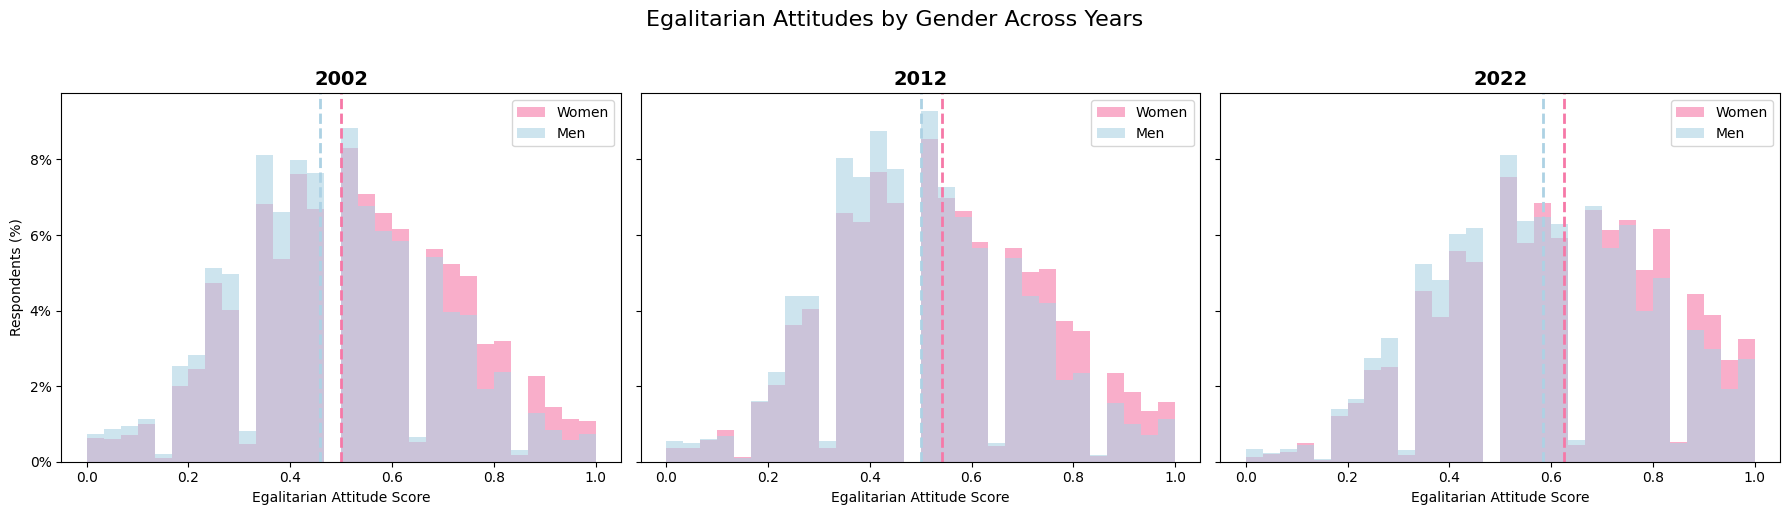

In [36]:
# men_color = '#4C72B0'
# women_color = '#DD8452'
men_color = '#add2e4'
women_color = '#f678a7'

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

for ax, year, df in zip(axes, years, dfs):
    # Prepare data
    female_vals = df.loc[df['sex'] == 'Female', 'eg_score_norm'].dropna().to_numpy()
    male_vals = df.loc[df['sex'] == 'Male', 'eg_score_norm'].dropna().to_numpy()

    # Medians for reference lines

    men_mean = np.median(male_vals) if male_vals.size else np.nan
    women_mean = np.median(female_vals) if female_vals.size else np.nan

    # Percentage weights (each dataset sums to 100%)
    female_weights = np.ones_like(female_vals, dtype=float) * (100.0 / female_vals.size) if female_vals.size else None
    male_weights = np.ones_like(male_vals, dtype=float) * (100.0 / male_vals.size) if male_vals.size else None

    # Histograms (percent per bin)
    ax.hist(
        female_vals,
        bins=30,
        weights=female_weights,
        alpha=0.6,
        label='Women',
        color=women_color
    )
    ax.hist(
        male_vals,
        bins=30,
        weights=male_weights,
        alpha=0.6,
        label='Men',
        color=men_color
    )

    # Median lines
    if not np.isnan(men_mean):
        ax.axvline(men_mean, linestyle='--', linewidth=2, color=men_color)
    if not np.isnan(women_mean):
        ax.axvline(women_mean, linestyle='--', linewidth=2, color=women_color)

    ax.set_xlabel('Egalitarian Attitude Score')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

axes[0].set_ylabel('Respondents (%)')
fig.suptitle('Egalitarian Attitudes by Gender Across Years', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [33]:
men_color = '#add2e4'
women_color = '#f678a7'

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

# Create subplots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('2002', '2012', '2022'),
    horizontal_spacing=0.08
)

for col, (year, df) in enumerate(zip(years, dfs), 1):
    # Prepare data
    female_vals = df.loc[df['sex'] == 'Female', 'eg_score_norm'].dropna().to_numpy()
    male_vals = df.loc[df['sex'] == 'Male', 'eg_score_norm'].dropna().to_numpy()
    
    # Calculate medians
    men_median = np.median(male_vals) if male_vals.size else np.nan
    women_median = np.median(female_vals) if female_vals.size else np.nan
    
    # Add histograms (using histnorm='percent')
    fig.add_trace(
        go.Histogram(
            x=female_vals,
            name='Women',
            marker_color=women_color,
            opacity=0.6,
            nbinsx=30,
            histnorm='percent',
            showlegend=(col == 1)
        ),
        row=1, col=col
    )
    
    fig.add_trace(
        go.Histogram(
            x=male_vals,
            name='Men',
            marker_color=men_color,
            opacity=0.6,
            nbinsx=30,
            histnorm='percent',
            showlegend=(col == 1)
        ),
        row=1, col=col
    )
    
    # Add median lines
    if not np.isnan(women_median):
        fig.add_vline(
            x=women_median,
            line_dash="dash",
            line_color=women_color,
            line_width=2,
            row=1, col=col
        )
    
    if not np.isnan(men_median):
        fig.add_vline(
            x=men_median,
            line_dash="dash",
            line_color=men_color,
            line_width=2,
            row=1, col=col
        )
    
    # Update x-axis label
    fig.update_xaxes(title_text='Egalitarian Attitude Score', row=1, col=col)

# Update y-axis
fig.update_yaxes(title_text='Respondents (%)', row=1, col=1)

# Update layout
fig.update_layout(
    title_text='Egalitarian Attitudes by Gender Across Years',
    title_font_size=16,
    height=500,
    width=1400,
    barmode='overlay',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
pio.renderers.default = "browser"
fig.show()

In [30]:
df_2002[(df_2002["eg_score"] > 2.84) & (df_2002["eg_score"] < 3)]["eg_score"]

Series([], Name: eg_score, dtype: float64)

In [35]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

men_color = '#add2e4'
women_color = '#f678a7'

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

fig = make_subplots(
    rows=1, cols=3,
    shared_yaxes=True,
    subplot_titles=[str(y) for y in years]
)

for i, (year, df) in enumerate(zip(years, dfs), start=1):

    female_vals = df.loc[df['sex'] == 'Female', 'eg_score_norm'].dropna().to_numpy()
    male_vals   = df.loc[df['sex'] == 'Male',   'eg_score_norm'].dropna().to_numpy()

    # Histograms (normalized to percent)
    fig.add_trace(
        go.Histogram(
            x=female_vals,
            nbinsx=30,
            histnorm='percent',
            name='Women',
            marker_color=women_color,
            opacity=0.6,
            showlegend=(i == 1)
        ),
        row=1, col=i
    )

    fig.add_trace(
        go.Histogram(
            x=male_vals,
            nbinsx=30,
            histnorm='percent',
            name='Men',
            marker_color=men_color,
            opacity=0.6,
            showlegend=(i == 1)
        ),
        row=1, col=i
    )

    # Median lines
    if male_vals.size:
        fig.add_vline(
            x=np.median(male_vals),
            line=dict(color=men_color, dash='dash', width=2),
            row=1, col=i
        )

    if female_vals.size:
        fig.add_vline(
            x=np.median(female_vals),
            line=dict(color=women_color, dash='dash', width=2),
            row=1, col=i
        )

fig.update_layout(
    title='Egalitarian Attitudes by Gender Across Years',
    barmode='overlay',
    height=500,
    width=1200,
    legend=dict(title='Gender'),
)

fig.update_xaxes(title_text='Egalitarian Attitude Score')
fig.update_yaxes(title_text='Respondents (%)', ticksuffix='%')
pio.renderers.default = "browser"
fig.show()


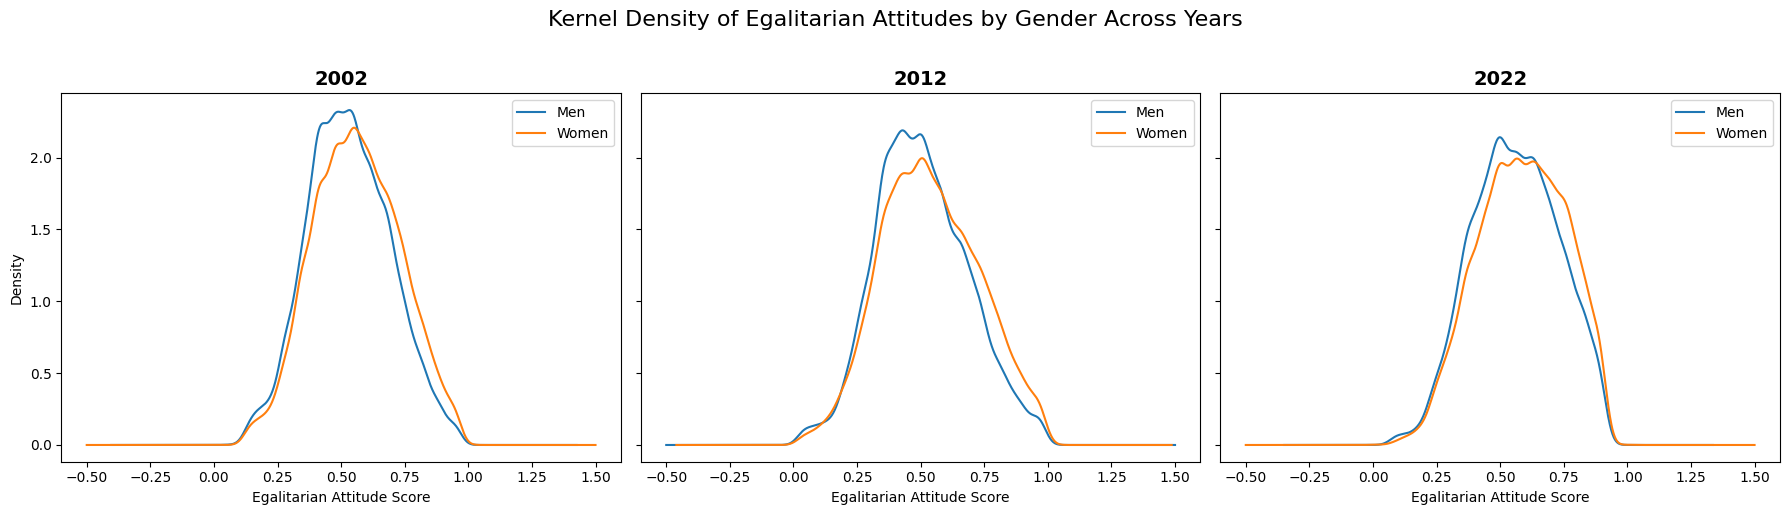

In [259]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

for ax, year, df in zip(axes, years, dfs):
    df.loc[df['sex'] == 'Male', 'eg_score_norm'].plot(
        kind='kde', label='Men', ax=ax
    )
    
    df.loc[df['sex'] == 'Female', 'eg_score_norm'].plot(
        kind='kde', label='Women', ax=ax
    )
    
    ax.set_xlabel('Egalitarian Attitude Score')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.legend()

axes[0].set_ylabel('Density')
fig.suptitle('Kernel Density of Egalitarian Attitudes by Gender Across Years', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

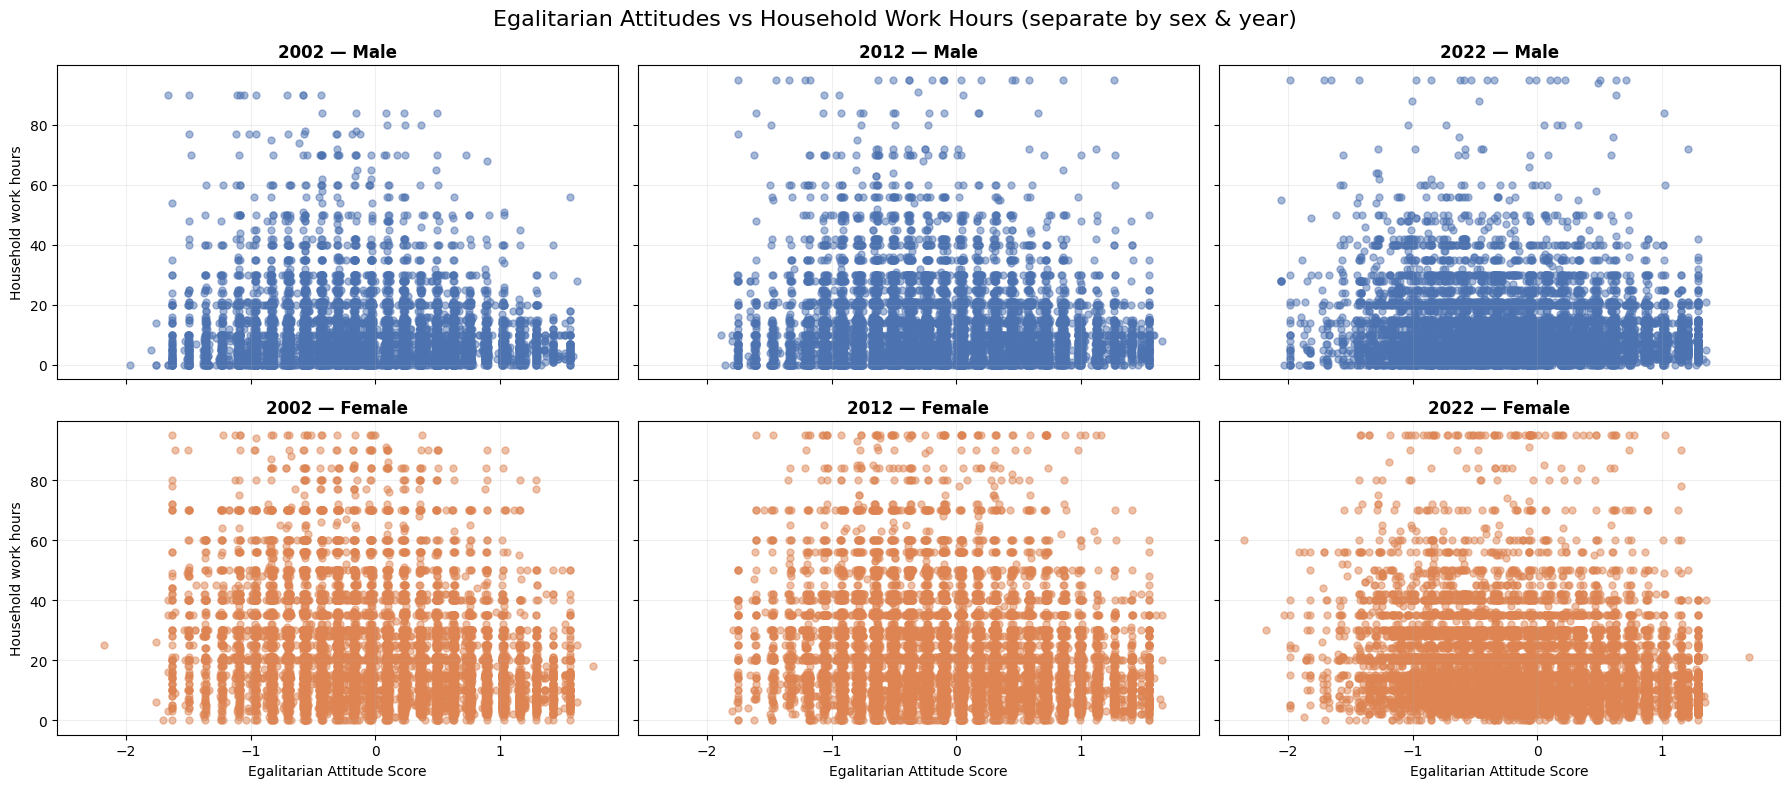

In [260]:
men_color = '#4C72B0'
women_color = '#DD8452'

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sex_rows = ["Male", "Female"]
colors = {"Male": men_color, "Female": women_color}

for col, (year, df) in enumerate(zip(years, dfs)):
    sub = df.dropna(subset=["eg_score", "hh_wrk_hrs", "sex"])
    for row, sex in enumerate(sex_rows):
        ax = axes[row, col]
        ax.scatter(
            sub.loc[sub["sex"] == sex, "eg_score"],
            sub.loc[sub["sex"] == sex, "hh_wrk_hrs"],
            color=colors[sex], alpha=0.5, s=25, label=sex
        )
        if row == 1:
            ax.set_xlabel("Egalitarian Attitude Score")
        if col == 0:
            ax.set_ylabel("Household work hours")
        ax.set_title(f"{year} — {sex}", fontsize=12, fontweight="bold")
        ax.grid(alpha=0.2)

fig.suptitle("Egalitarian Attitudes vs Household Work Hours (separate by sex & year)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## Correlation between eg_score and household work hours by sex and year

In [261]:
years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sexes = ["Male", "Female"]

rows = []
for year, df in zip(years, dfs):
    sub = df.dropna(subset=["eg_score", "hh_wrk_hrs", "sex"])
    for sex in sexes:
        d = sub[sub["sex"] == sex]
        r = d["eg_score"].corr(d["hh_wrk_hrs"])
        rows.append({"year": year, "sex": sex, "correlation": r})

corr_df = pd.DataFrame(rows)
corr_df

,year,sex,correlation
0,2002,Male,-0.065663
1,2002,Female,-0.253789
2,2012,Male,-0.070796
3,2012,Female,-0.207833
4,2022,Male,-0.135390
5,2022,Female,-0.227598


## Conclusion
For Females, 
the correlation is negative, which means as women become more egalitarian, they reduce household work hours, which can be because they resist traditional gender norms. 

For Men,
The correlation coefficient remains close to zero, indicationg no effect of becoming more or less egalitarian

## Three way correlation between eg_score, hh work hours and paid work hours
 To check whether increase in eg score and reduction in hh work hours is just because of becoming more educated and increasing paid work

In [262]:
df_2022[df_2022["sex"] == "Male"][["eg_score", "hh_wrk_hrs", "wrk_hrs"]].corr()

,eg_score,hh_wrk_hrs,wrk_hrs
eg_score,1.00000,-0.135390,-0.061790
hh_wrk_hrs,-0.13539,1.000000,0.045498
wrk_hrs,-0.06179,0.045498,1.000000


In [263]:
df_2022[df_2022["sex"] == "Female"][["eg_score", "hh_wrk_hrs", "wrk_hrs"]].corr()

,eg_score,hh_wrk_hrs,wrk_hrs
eg_score,1.000000,-0.227598,-0.014493
hh_wrk_hrs,-0.227598,1.000000,0.039618
wrk_hrs,-0.014493,0.039618,1.000000


## Making a regression model to check the association between eg_scores and wrk_hrs

In [264]:
# Prepare data
data = df_2002[["wrk_hrs", "eg_score", "sex"]].copy()

# Convert wrk_hrs to numeric (handles strings, invalid values → NaN)
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")

# Drop rows with any missing values
data = data.dropna()

# Convert sex to numeric (0 = Female, 1 = Male)
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

model = smf.ols(
    "wrk_hrs ~ eg_score * sex_numeric",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wrk_hrs   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     582.1
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:13:16   Log-Likelihood:                -67984.
No. Observations:               16525   AIC:                         1.360e+05
Df Residuals:                   16521   BIC:                         1.360e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               36.8876 

In [265]:
# Prepare data
data = df_2002[["hh_wrk_hrs", "eg_score", "sex"]].copy()

# Convert wrk_hrs to numeric (handles strings, invalid values → NaN)
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with any missing values
data = data.dropna()

# Convert sex to numeric (0 = Female, 1 = Male)
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

model = smf.ols(
    "hh_wrk_hrs ~ eg_score * sex_numeric",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             hh_wrk_hrs   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     2421.
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:13:16   Log-Likelihood:            -1.0175e+05
No. Observations:               25375   AIC:                         2.035e+05
Df Residuals:                   25371   BIC:                         2.035e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               22.1951 

In [266]:
# Prepare data (include hh_wrk_hrs as predictor)
data = df_2002[["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"]].copy()

# Ensure numeric
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with missing
data = data.dropna(subset=["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"])

# Encode sex
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

# Include hh_wrk_hrs as independent variable
model = smf.ols(
    "wrk_hrs ~ eg_score * sex_numeric + hh_wrk_hrs",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wrk_hrs   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     416.6
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:13:17   Log-Likelihood:                -64842.
No. Observations:               15808   AIC:                         1.297e+05
Df Residuals:                   15803   BIC:                         1.297e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               37.3961 

In [267]:
# Prepare data (include hh_wrk_hrs as predictor)
data = df_2002[["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"]].copy()

# Ensure numeric
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with missing
data = data.dropna(subset=["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"])

# Encode sex
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

# Include hh_wrk_hrs as independent variable
model = smf.ols(
    "hh_wrk_hrs ~ eg_score * sex_numeric + wrk_hrs",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             hh_wrk_hrs   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     949.2
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:13:17   Log-Likelihood:                -59876.
No. Observations:               15808   AIC:                         1.198e+05
Df Residuals:                   15803   BIC:                         1.198e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               19.1342 

### The above regression model for all 3 years

In [268]:
years = [2002, 2012, 2022]
dfs = {
    2002: df_2002,
    2012: df_2012,
    2022: df_2022
}

# Models you want to run (same spec each year)
MODEL_SPECS = {
    "M1_paid_on_egal": "wrk_hrs ~ eg_score * sex_numeric",
    "M2_house_on_egal": "hh_wrk_hrs ~ eg_score * sex_numeric",
    "M3_paid_on_egal_plus_house": "wrk_hrs ~ eg_score * sex_numeric + hh_wrk_hrs",
    "M4_house_on_egal_plus_paid": "hh_wrk_hrs ~ eg_score * sex_numeric + wrk_hrs",
}

# Minimal output: only what you need to interpret + compare
KEEP_TERMS = ["eg_score", "sex_numeric", "eg_score:sex_numeric", "hh_wrk_hrs", "wrk_hrs"]

# -----------------------------
# Helper to run & collect output
# -----------------------------
def run_year_models(df, year):
    df = df.copy()

    # Ensure numeric (coerce invalid to NaN)
    for c in ["wrk_hrs", "hh_wrk_hrs", "eg_score"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Encode sex (0 = Female, 1 = Male)
    df = df.dropna(subset=["sex"])
    df["sex_numeric"] = (df["sex"] == "Male").astype(int)

    out_rows = []

    for model_name, formula in MODEL_SPECS.items():
        # Identify required columns for this formula
        required = ["eg_score", "sex_numeric"]
        if "wrk_hrs" in formula:
            required.append("wrk_hrs")
        if "hh_wrk_hrs" in formula:
            required.append("hh_wrk_hrs")

        data = df.dropna(subset=required).copy()

        # Fit
        res = smf.ols(formula, data=data).fit()

        # Collect only what you need
        params = res.params
        bse = res.bse
        pvals = res.pvalues

        # Compute slopes for women (sex=0) and men (sex=1)
        # Women slope on eg_score = beta_eg
        # Men slope on eg_score = beta_eg + beta_interaction
        beta_eg = params.get("eg_score", np.nan)
        beta_int = params.get("eg_score:sex_numeric", 0.0)  # if term absent, treat as 0
        slope_women = beta_eg
        slope_men = beta_eg + beta_int

        row = {
            "year": year,
            "model": model_name,
            "n": int(res.nobs),
            "r2": float(res.rsquared),
            "beta_eg_score": float(beta_eg) if pd.notnull(beta_eg) else np.nan,
            "beta_interaction": float(params.get("eg_score:sex_numeric", np.nan)),
            "slope_eg_women": float(slope_women) if pd.notnull(slope_women) else np.nan,
            "slope_eg_men": float(slope_men) if pd.notnull(slope_men) else np.nan,
            "p_eg_score": float(pvals.get("eg_score", np.nan)),
            "p_interaction": float(pvals.get("eg_score:sex_numeric", np.nan)),
        }

        # Add only the extra covariate if present in that model
        if "hh_wrk_hrs" in formula:
            row["beta_hh_wrk_hrs"] = float(params.get("hh_wrk_hrs", np.nan))
            row["p_hh_wrk_hrs"] = float(pvals.get("hh_wrk_hrs", np.nan))
        else:
            row["beta_hh_wrk_hrs"] = np.nan
            row["p_hh_wrk_hrs"] = np.nan

        if "wrk_hrs" in formula and model_name == "M4_house_on_egal_plus_paid":
            row["beta_wrk_hrs"] = float(params.get("wrk_hrs", np.nan))
            row["p_wrk_hrs"] = float(pvals.get("wrk_hrs", np.nan))
        else:
            row["beta_wrk_hrs"] = np.nan
            row["p_wrk_hrs"] = np.nan

        out_rows.append(row)

    return pd.DataFrame(out_rows)

# -----------------------------
# Run all years & show once
# -----------------------------
all_results = []
for y in years:
    all_results.append(run_year_models(dfs[y], y))

results_df = pd.concat(all_results, ignore_index=True)

# Optional: nicer ordering
results_df = results_df[
    [
        "year", "model", "n", "r2",
        "beta_eg_score", "beta_interaction",
        "slope_eg_women", "slope_eg_men",
        "beta_hh_wrk_hrs", "beta_wrk_hrs",
        "p_eg_score", "p_interaction", "p_hh_wrk_hrs", "p_wrk_hrs"
    ]
].sort_values(["model", "year"]).reset_index(drop=True)

# Display
results_df

,year,model,n,r2,beta_eg_score,beta_interaction,slope_eg_women,slope_eg_men,beta_hh_wrk_hrs,beta_wrk_hrs,p_eg_score,p_interaction,p_hh_wrk_hrs,p_wrk_hrs
0,2002,M1_paid_on_egal,16525,0.095592,-1.189605,-0.646300,-1.189605,-1.835905,NaN,NaN,3.753775e-06,7.270133e-02,NaN,NaN
1,2012,M1_paid_on_egal,17660,0.074168,-1.651787,-0.098171,-1.651787,-1.749959,NaN,NaN,6.649634e-12,7.674666e-01,NaN,NaN
2,2022,M1_paid_on_egal,12832,0.055452,-0.280803,-0.904691,-0.280803,-1.185495,NaN,NaN,2.526562e-01,7.863456e-03,NaN,NaN
3,2002,M2_house_on_egal,15808,0.193377,-4.721247,4.106184,-4.721247,-0.615063,NaN,NaN,2.006644e-134,3.233123e-53,NaN,NaN
4,2012,M2_house_on_egal,17305,0.128312,-3.616197,2.603376,-3.616197,-1.012822,NaN,NaN,4.115174e-89,1.114421e-25,NaN,NaN
5,2022,M2_house_on_egal,12455,0.090827,-4.221799,1.757657,-4.221799,-2.464141,NaN,NaN,4.059419e-88,1.660226e-09,NaN,NaN
6,2002,M3_paid_on_egal_plus_house,15808,0.095386,-1.247675,-0.456303,-1.247675,-1.703977,-0.028205,NaN,2.398248e-06,2.142397e-01,0.009595,NaN
7,2012,M3_paid_on_egal_plus_house,17305,0.074558,-1.816354,0.003061,-1.816354,-1.813293,-0.038031,NaN,1.481090e-13,9.927400e-01,0.000215,NaN
8,2022,M3_paid_on_egal_plus_house,12455,0.055693,-0.031459,-1.032613,-0.031459,-1.064072,0.043975,NaN,9.016011e-01,2.943607e-03,0.000037,NaN
9,2002,M4_house_on_egal_plus_paid,15808,0.193719,-4.738019,4.097575,-4.738019,-0.640444,NaN,-0.015048,3.044763e-135,5.164169e-53,NaN,0.009595


## Plotting mean eg_scores by country

In [269]:
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except Exception:
        return None

def plot_mean_eg_map(df, title):
    tmp = df.copy()
    # handle values like "DE-Germany" or bare ISO2
    tmp["iso2"] = tmp["country"].astype(str).str.split("-", n=1).str[0].str.strip()
    tmp["iso3"] = tmp["iso2"].apply(iso2_to_iso3)
    tmp = tmp.dropna(subset=["iso3"])
    country_mean = tmp.groupby("iso3", as_index=False)["eg_score"].mean()

    fig = px.choropleth(
        country_mean,
        locations="iso3",
        locationmode="ISO-3",
        color="eg_score",
        color_continuous_scale="Viridis",
        labels={"eg_score": "Mean egalitarian score"},
        title=title,
    )
    fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
    pio.renderers.default = "browser"
    fig.show()

plot_mean_eg_map(df_2002, "Mean egalitarian score (2002)")
plot_mean_eg_map(df_2012, "Mean egalitarian score (2012)")
plot_mean_eg_map(df_2022, "Mean egalitarian score (2022)")

## Checking Correlation between age and eg_score 
Obvious result- Eg_score decreases with age

In [270]:
print(df_2002[["age", "eg_score_norm"]].corr())
print(df_2012[["age", "eg_score_norm"]].corr())
print(df_2022[["age", "eg_score_norm"]].corr())

                    age  eg_score_norm
age            1.000000      -0.176879
eg_score_norm -0.176879       1.000000
                    age  eg_score_norm
age            1.000000      -0.038256
eg_score_norm -0.038256       1.000000
                    age  eg_score_norm
age            1.000000       0.037268
eg_score_norm  0.037268       1.000000


In [271]:
# Compute mean eg_score by age_bin for each year
eg_2002 = df_2002[df_2002["sex"] == "Male"].groupby("age_bin")["eg_score_norm"].mean()
eg_2012 = df_2012[df_2012["sex"] == "Male"].groupby("age_bin")["eg_score_norm"].mean()
eg_2022 = df_2022[df_2022["sex"] == "Male"].groupby("age_bin")["eg_score_norm"].mean()

# Combine into one DataFrame
df_eg_score_by_age_male = pd.DataFrame({
    "2002": eg_2002,
    "2012": eg_2012,
    "2022": eg_2022
})

df_eg_score_by_age_male

,2002,2012,2022
age_bin,,,
18-25,0.529608,0.461774,0.473763
26-35,0.563191,0.505675,0.533114
36-45,0.556556,0.517659,0.559994
46-55,0.545600,0.518840,0.570752
56-65,0.513550,0.514103,0.572110
66-75,0.475286,0.486564,0.566701
75+,0.448821,0.452152,0.537660


In [272]:
# Compute mean eg_score by age_bin for each year
eg_2002 = df_2002[df_2002["sex"] == "Female"].groupby("age_bin")["eg_score_norm"].mean()
eg_2012 = df_2012[df_2012["sex"] == "Female"].groupby("age_bin")["eg_score_norm"].mean()
eg_2022 = df_2022[df_2022["sex"] == "Female"].groupby("age_bin")["eg_score_norm"].mean()

# Combine into one DataFrame
df_eg_score_by_age_female = pd.DataFrame({
    "2002": eg_2002,
    "2012": eg_2012,
    "2022": eg_2022
})

df_eg_score_by_age_female

,2002,2012,2022
age_bin,,,
18-25,0.551810,0.469647,0.511628
26-35,0.578941,0.531365,0.550887
36-45,0.586881,0.544202,0.581377
46-55,0.569649,0.550797,0.595839
56-65,0.536885,0.546909,0.601828
66-75,0.493638,0.532430,0.596260
75+,0.477138,0.468123,0.569796


In [273]:
eg_score_by_year = pd.DataFrame({
    "2002": [df_2002["eg_score_norm"].mean()],
    "2012": [df_2012["eg_score_norm"].mean()],
    "2022": [df_2022["eg_score_norm"].mean()]
})
eg_score_by_year

,2002,2012,2022
0,0.547463,0.522104,0.573461


## Change in eg_scores by education

In [274]:
order = ["No/Primary", "Secondary", "Post-sec / Short tertiary", "University+"]

idx = (
    pd.Index(df_2002["educ_4_label"].dropna().unique())
    .union(df_2012["educ_4_label"].dropna().unique())
    .union(df_2022["educ_4_label"].dropna().unique())
)

means_by_educ = pd.DataFrame(index=idx, columns=["2002", "2012", "2022"])
means_by_educ["2002"] = df_2002.groupby("educ_4_label")["eg_score"].mean()
means_by_educ["2012"] = df_2012.groupby("educ_4_label")["eg_score"].mean()
means_by_educ["2022"] = df_2022.groupby("educ_4_label")["eg_score"].mean()

means_by_educ = means_by_educ.reindex(order)
means_by_educ

,2002,2012,2022
No/Primary,-0.299276,-0.361977,-0.506701
Secondary,0.020114,-0.078605,-0.148925
Post-sec / Short tertiary,-0.009170,0.188369,0.051325
University+,0.292637,0.401340,0.233810


In [275]:
df_2002[(df_2002["educ_4"] >= 2) & 
        (~df_2002["high_egal"]) & 
        (df_2002["sex"] == "Male")]["hh_wrk_hrs"].mean()

np.float64(9.46504758779127)

In [276]:
df_2002[(df_2002["educ_4"] < 2) & 
        (~df_2002["high_egal"]) & 
        (df_2002["sex"] == "Male")]["hh_wrk_hrs"].mean()

np.float64(9.41895482728078)

In [277]:
df_2002[(df_2002["educ_4"] >= 2) & 
        (df_2002["high_egal"]) &
        (df_2002["sex"] == "Female")]["hh_wrk_hrs"].mean()

np.float64(17.60725668055896)

In [278]:
df_2002[(df_2002["educ_4"] < 2) & 
        (df_2002["high_egal"]) & 
        (df_2002["sex"] == "Female")]["hh_wrk_hrs"].mean()

np.float64(20.352843365480545)

In [279]:
def hh_confusion(df):
    return (
        df.pivot_table(
            index="sex",
            columns="high_egal",
            values="hh_wrk_hrs",
            aggfunc="mean"
        )
        .rename(columns={True: "High egal", False: "Low egal"})
        .loc[["Male", "Female"]]
    )

cm_2002 = hh_confusion(df_2002)
cm_2012 = hh_confusion(df_2012)
cm_2022 = hh_confusion(df_2022)

cm_2002, cm_2012, cm_2022

(high_egal   Low egal  High egal
 sex                            
 Male        9.463878   8.468106
 Female     25.429174  18.802609,
 high_egal   Low egal  High egal
 sex                            
 Male       10.834760   9.820317
 Female     23.428128  17.983593,
 high_egal   Low egal  High egal
 sex                            
 Male       12.361864  10.218216
 Female     21.028806  15.641142)

In [280]:
def hh_confusion_by_educ(df):
    # require educ_4 and hh_wrk_hrs present
    return (
        df.pivot_table(
            index="sex",
            columns=df["educ_4"] >= 2,
            values="hh_wrk_hrs",
            aggfunc="mean"
        )
        .rename(columns={True: "Educ ≥2", False: "Educ <2"})
        .loc[["Male", "Female"]]
    )

cm_2002_educ = hh_confusion_by_educ(df_2002)
cm_2012_educ = hh_confusion_by_educ(df_2012)
cm_2022_educ = hh_confusion_by_educ(df_2022)

cm_2002_educ, cm_2012_educ, cm_2022_educ


(educ_4    Educ <2    Educ ≥2
 sex                         
 Male     9.184168   8.873818
 Female  23.857923  20.093782,
 educ_4    Educ <2    Educ ≥2
 sex                         
 Male    10.848945   9.105469
 Female  22.283987  16.166424,
 educ_4    Educ <2    Educ ≥2
 sex                         
 Male    11.753899  10.956666
 Female  19.955563  16.293393)

In [281]:
df_2002[["hh_wrk_hrs", "educ_4"]].corr()

,hh_wrk_hrs,educ_4
hh_wrk_hrs,1.00000,-0.14047
educ_4,-0.14047,1.00000


In [282]:
df_2002[df_2002["sex"]=="Male"].groupby("code_income_control")["eg_score_norm"].mean()

code_income_control
Financial control is separate               0.571713
Financial control is shared                 0.546592
Financial control is with the partner       0.496788
Financial control is with the respondent    0.468103
Name: eg_score_norm, dtype: float64

In [283]:
df_2002[df_2002["sex"]=="Female"].groupby("code_income_control")["eg_score_norm"].mean()

code_income_control
Financial control is separate               0.604363
Financial control is shared                 0.580074
Financial control is with the partner       0.476775
Financial control is with the respondent    0.517021
Name: eg_score_norm, dtype: float64

In [284]:
df_2022.groupby("code_income_control")["eg_score_norm"].mean()

code_income_control
Financial control is separate               0.608476
Financial control is shared                 0.595591
Financial control is with the partner       0.487619
Financial control is with the respondent    0.491387
Name: eg_score_norm, dtype: float64

In [285]:
df_2002.groupby("code_higher_income")["eg_score_norm"].mean()

code_higher_income
Partner has higher income       0.577611
Partner has no income           0.482941
Respondent has higher income    0.555779
Respondent has no income        0.483197
Same income                     0.559138
Name: eg_score_norm, dtype: float64

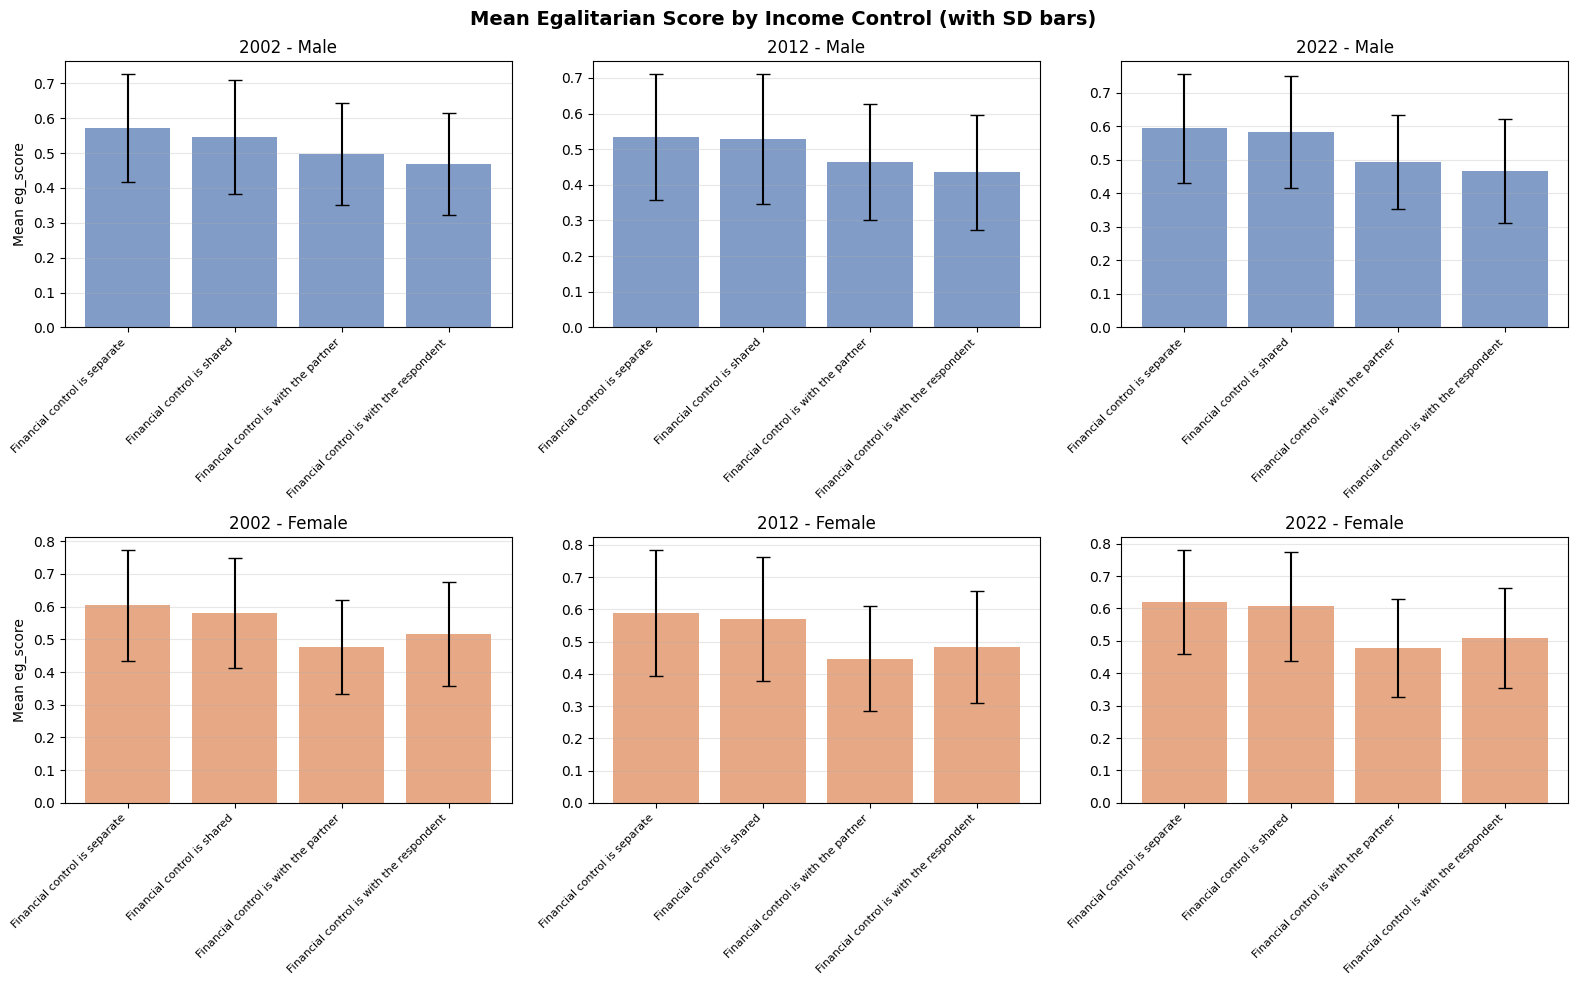

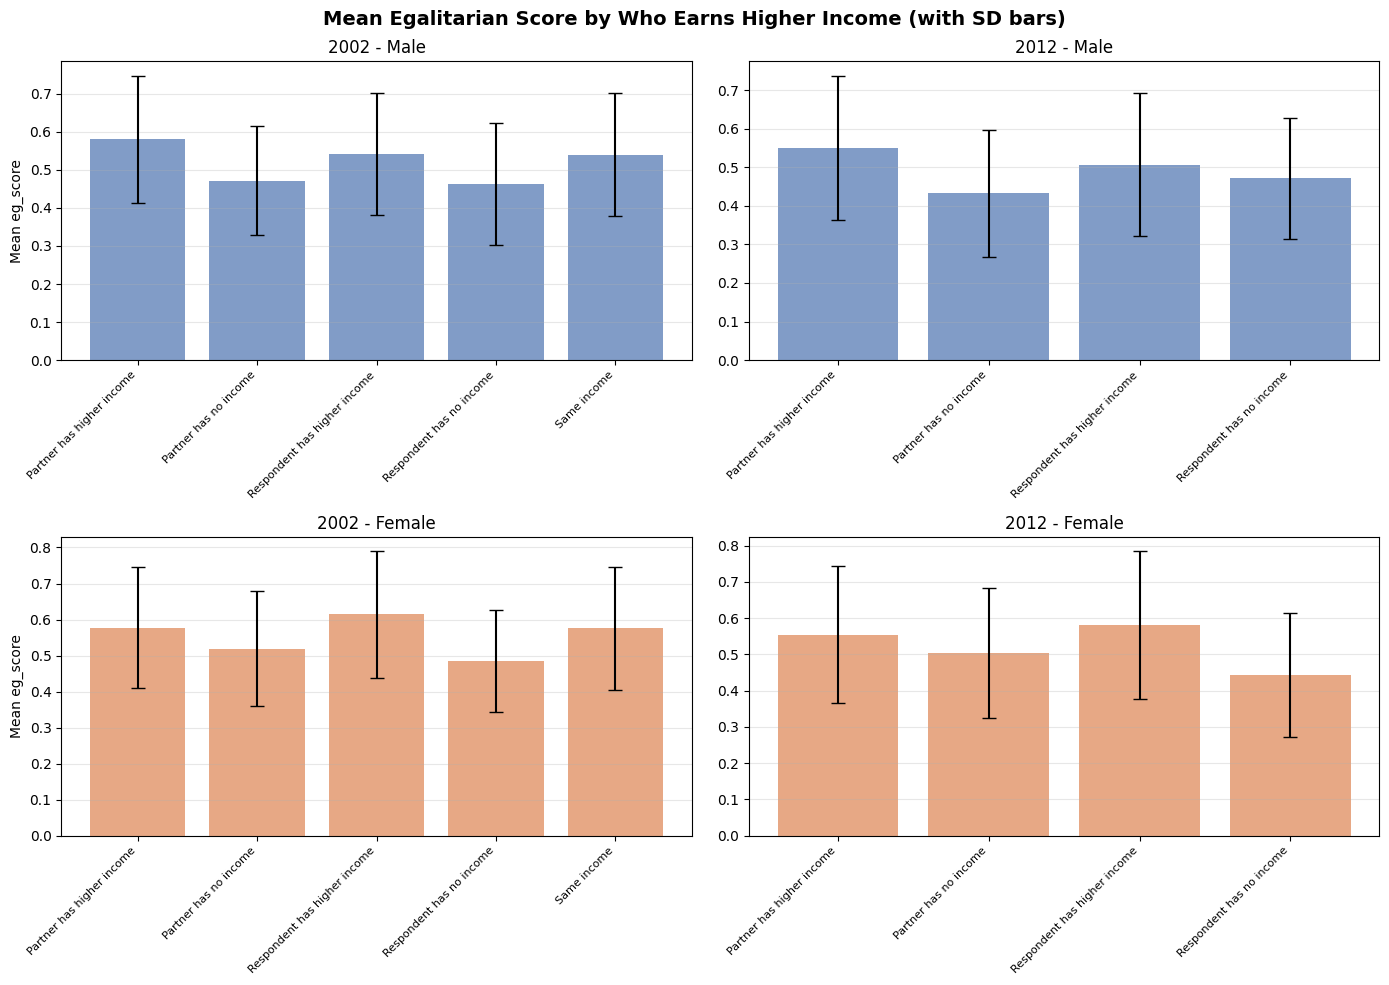

In [286]:
import matplotlib.pyplot as plt
import numpy as np

# Define consistent colors for genders
male_color = '#4C72B0'
female_color = '#DD8452'
color_map = {"Male": male_color, "Female": female_color}

# Plot mean eg_score with SD bars for code_income_control by gender
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sexes = ["Male", "Female"]

# ===== code_income_control =====
for col, (year, df) in enumerate(zip(years, dfs)):
    for row, sex in enumerate(sexes):
        ax = axes[row, col]
        sub = df[df["sex"] == sex].dropna(subset=["code_income_control", "eg_score_norm"])
        
        # Calculate mean and std
        grouped = sub.groupby("code_income_control")["eg_score_norm"].agg(["mean", "std", "count"])
        
        # Create bar plot with error bars
        x_pos = np.arange(len(grouped))
        ax.bar(x_pos, grouped["mean"], yerr=grouped["std"], capsize=5, alpha=0.7, color=color_map[sex])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(grouped.index, rotation=45, ha="right", fontsize=8)
        ax.set_ylabel("Mean eg_score" if col == 0 else "")
        ax.set_title(f"{year} - {sex}")
        ax.grid(axis="y", alpha=0.3)

plt.suptitle("Mean Egalitarian Score by Income Control (with SD bars)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# ===== code_higher_income (only for 2002 and 2012) =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

years_income = [2002, 2012]
dfs_income = [df_2002, df_2012]

for col, (year, df) in enumerate(zip(years_income, dfs_income)):
    for row, sex in enumerate(sexes):
        ax = axes[row, col]
        sub = df[df["sex"] == sex].dropna(subset=["code_higher_income", "eg_score_norm"])
        
        # Calculate mean and std
        grouped = sub.groupby("code_higher_income")["eg_score_norm"].agg(["mean", "std", "count"])
        
        # Create bar plot with error bars
        x_pos = np.arange(len(grouped))
        ax.bar(x_pos, grouped["mean"], yerr=grouped["std"], capsize=5, alpha=0.7, color=color_map[sex])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(grouped.index, rotation=45, ha="right", fontsize=8)
        ax.set_ylabel("Mean eg_score" if col == 0 else "")
        ax.set_title(f"{year} - {sex}")
        ax.grid(axis="y", alpha=0.3)

plt.suptitle("Mean Egalitarian Score by Who Earns Higher Income (with SD bars)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [287]:
df_2012['code_higher_income'].unique()

array([nan, 'Respondent has no income', 'Partner has higher income',
       'Respondent has higher income', 'Partner has no income'],
      dtype=object)

In [288]:
# Display categories and order for x-axis variables
print("=" * 80)
print("CATEGORIES FOR code_income_control")
print("=" * 80)

for year, df in zip([2002, 2012, 2022], [df_2002, df_2012, df_2022]):
    print(f"\n{year}:")
    categories = df["code_income_control"].dropna().unique()
    for i, cat in enumerate(categories, 1):
        print(f"  {i}. {cat}")

print("\n" + "=" * 80)
print("CATEGORIES FOR code_higher_income")
print("=" * 80)

for year, df in zip([2002, 2012], [df_2002, df_2012]):
    print(f"\n{year}:")
    categories = df["code_higher_income"].dropna().unique()
    for i, cat in enumerate(categories, 1):
        print(f"  {i}. {cat}")


CATEGORIES FOR code_income_control

2002:
  1. Financial control is shared
  2. Financial control is with the respondent
  3. Financial control is separate
  4. Financial control is with the partner

2012:
  1. Financial control is shared
  2. Financial control is separate
  3. Financial control is with the partner
  4. Financial control is with the respondent

2022:
  1. Financial control is with the respondent
  2. Financial control is separate
  3. Financial control is shared
  4. Financial control is with the partner

CATEGORIES FOR code_higher_income

2002:
  1. Respondent has higher income
  2. Same income
  3. Partner has higher income
  4. Partner has no income
  5. Respondent has no income

2012:
  1. Respondent has no income
  2. Partner has higher income
  3. Respondent has higher income
  4. Partner has no income


In [289]:
# Plotly boxplots for code_income_control
years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sexes = ["Male", "Female"]

# Prepare data for plotly
data_for_plot = []

for year, df in zip(years, dfs):
    for sex in sexes:
        sub = df[df["sex"] == sex].dropna(subset=["code_income_control", "eg_score_norm"])
        for control_type in sub["code_income_control"].unique():
            subset = sub[sub["code_income_control"] == control_type]
            for score in subset["eg_score_norm"]:
                data_for_plot.append({
                    "year": year,
                    "sex": sex,
                    "code_income_control": control_type,
                    "eg_score_norm": score
                })

df_plot = pd.DataFrame(data_for_plot)

# Create subplots for code_income_control by year
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("2002", "2012", "2022")
)

for col, year in enumerate(years, 1):
    df_year = df_plot[df_plot["year"] == year]
    for sex, color in [("Male", '#4C72B0'), ("Female", '#DD8452')]:
        df_sex = df_year[df_year["sex"] == sex]
        fig.add_trace(
            go.Box(
                x=df_sex["code_income_control"],
                y=df_sex["eg_score_norm"],
                name=sex,
                marker=dict(color=color),
                boxmean=True,
                showlegend=(col == 1),
            ),
            row=1, col=col
        )

fig.update_xaxes(tickangle=45)
fig.update_layout(
    title_text="Egalitarian Score by Income Control (Boxplot)",
    height=500,
    width=1400,
    showlegend=True
)
fig.show()

# Prepare data for code_higher_income
data_for_plot_income = []

for year in [2002, 2012]:
    df = dfs[years.index(year)]
    for sex in sexes:
        sub = df[df["sex"] == sex].dropna(subset=["code_higher_income", "eg_score_norm"])
        for income_type in sub["code_higher_income"].unique():
            subset = sub[sub["code_higher_income"] == income_type]
            for score in subset["eg_score_norm"]:
                data_for_plot_income.append({
                    "year": year,
                    "sex": sex,
                    "code_higher_income": income_type,
                    "eg_score_norm": score
                })

df_plot_income = pd.DataFrame(data_for_plot_income)

# Create subplots for code_higher_income by year
fig2 = make_subplots(
    rows=1, cols=2,
    subplot_titles=("2002", "2012")
)

for col, year in enumerate([2002, 2012], 1):
    df_year = df_plot_income[df_plot_income["year"] == year]
    for sex, color in [("Male", '#4C72B0'), ("Female", '#DD8452')]:
        df_sex = df_year[df_year["sex"] == sex]
        fig2.add_trace(
            go.Box(
                x=df_sex["code_higher_income"],
                y=df_sex["eg_score_norm"],
                name=sex,
                marker=dict(color=color),
                boxmean=True,
                showlegend=(col == 1)
            ),
            row=1, col=col
        )

fig2.update_xaxes(tickangle=45)
fig2.update_layout(
    title_text="Egalitarian Score by Who Earns Higher Income (Boxplot)",
    height=500,
    width=1000,
    showlegend=True
)
fig2.show()


In [290]:
df_2012[(df_2012["marital"] == "Married") & (df_2012["FAM_DIF"] == "NAP")]

,V5_egal,V6_egal,V7_egal,V8_egal,V9_egal,V11_egal,V5_egal_z,V6_egal_z,V7_egal_z,V8_egal_z,...,LIFE_HAP,DIFF_CONC_WORK,HH_TIRED,HH_FAM,WORK_TIRED,HH_WEEKEND,COHAB,HOMPOP,COUNTRY,CASEID
5,4.0,2.0,2.0,2.0,4.0,2.0,0.230213,-0.787303,-0.858507,-0.726209,...,Fairly happy,NAP,NAP,0.0,NAP,Always partner,"Partner, same household",4.0,AR-Argentina,2.012000e+15
20,4.0,4.0,2.0,2.0,4.0,4.0,0.230213,0.848765,-0.858507,-0.726209,...,Very happy,NAP,NAP,70.0,NAP,About equal,"Partner, same household",3.0,AR-Argentina,2.012000e+15
23,2.0,2.0,2.0,2.0,2.0,2.0,-1.520823,-0.787303,-0.858507,-0.726209,...,Very happy,NAP,NAP,10.0,NAP,About equal,"Partner, same household",6.0,AR-Argentina,2.012000e+15
24,5.0,2.0,1.0,1.0,1.0,2.0,1.105731,-0.787303,-1.667756,-1.550327,...,Fairly happy,NAP,NAP,14.0,NAP,About equal,"Partner, same household",3.0,AR-Argentina,2.012000e+15
34,4.0,2.0,1.0,2.0,2.0,2.0,0.230213,-0.787303,-1.667756,-0.726209,...,Fairly happy,NAP,NAP,0.0,NAP,Always respondent,"Partner, same household",3.0,AR-Argentina,2.012000e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61733,4.0,4.0,4.0,4.0,2.0,4.0,0.230213,0.848765,0.759989,0.922025,...,Fairly happy,NAP,NAP,2.0,NAP,About equal,NaN,2.0,GB-GBN-Great Britain,2.012826e+15
61740,3.0,1.0,1.0,3.0,NaN,4.0,-0.645305,-1.605338,-1.667756,0.097908,...,Very happy,NAP,NAP,NaN,NAP,About equal,NaN,2.0,GB-GBN-Great Britain,2.012826e+15
61742,4.0,3.0,4.0,3.0,3.0,4.0,0.230213,0.030731,0.759989,0.097908,...,Fairly happy,NAP,NAP,28.0,NAP,About equal,NaN,2.0,GB-GBN-Great Britain,2.012826e+15
61745,4.0,4.0,4.0,4.0,2.0,5.0,0.230213,0.848765,0.759989,0.922025,...,Very happy,NAP,NAP,14.0,NAP,About equal,NaN,4.0,GB-GBN-Great Britain,2.012826e+15
